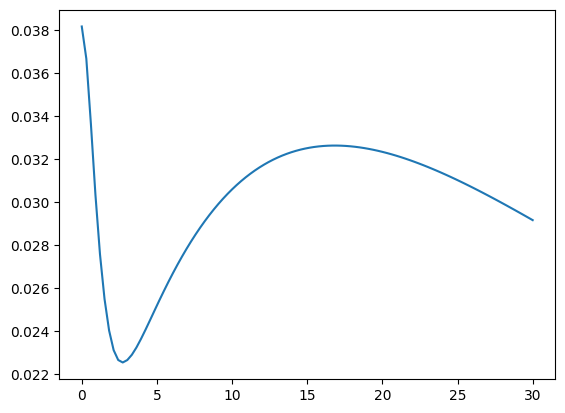

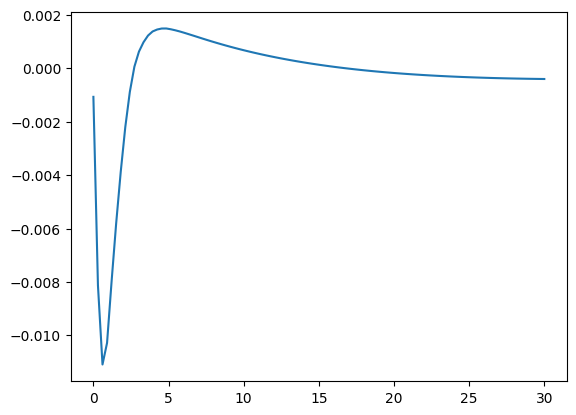

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Yields Data from ECB
current_yields = [
    (0.25, .03708004),
    (0.5, .03480834),
    (0.75, .03205257),
    (1.0, .02944257),
    (2.0, .02342641),
    (3.0, .02264375),
    (4.0, .02372672),
    (5.0, .02519909),
    (6.0, .02661483),
    (7.0, .02786643),
    (8.0, .02894020),
    (9.0, .02984566),
    (10.0, .03059704),
    (11.0, .03120873),
    (12.0, .03169425),
    (13.0, .03206610),
    (14.0, .03233577),
    (15.0, .03251381),
    (16.0, .03260989),
    (17.0, .03263287),
    (18.0, .03259087),
    (19.0, .03249129),
    (20.0, .03234093),
    (21.0, .03214597),
    (22.0, .03191205),
    (23.0, .03164432),
    (24.0, .03134746),
    (25.0, .03102571),
    (26.0, .03068293),
    (27.0, .03032262),
    (28.0, .02994794),
    (29.0, .02956175),
    (30.0, .02916661),
]

# Extract durations and yields
durations = [item[0] for item in current_yields]
yields = [item[1] for item in current_yields]

# Fit cubic spline
yield_curve = CubicSpline(durations, yields)

# Visualize the Fitted Curve
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields = yield_curve(maturities)   # Get the corresponding yields to maturity
plt.figure(1)
plt.plot(maturities, fitted_yields)

# Visualize the Fitted Curve dt
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields_dt = yield_curve.derivative(nu=1)(maturities)   # Get the corresponding yields to maturity
plt.figure(2)
plt.plot(maturities, fitted_yields_dt)
# To Be continued

In [2]:
# Simulation's Parameters
T = 20                  # Years of Simulation
days_per_year = 365     # Days in the Year
N = T*days_per_year     # Number of steps
dt = 1.0 * T / N        # Time step size
simulations = 100        # Amount of Monte Carlo runs
#np.random.seed(42)

# Parameters for the Hull-White model
a = 0.5         # Just some value
sigma = 0.025   # Assumed 250bps (to make things interesting)
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
r0 = .04

In [3]:
short_rate_paths = []
for n in range(simulations):
    Z = np.random.normal(0, 1, N)
    dr = np.zeros(N)
    r = np.zeros(N)
    r[0] = r0              # Should we initialize with initial rate from the market?
    for t in range(1, N):
        dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
        r[t] = r[t-1] + dr[t]
    short_rate_paths.append(r)
short_rate_paths = np.array(short_rate_paths)

In [4]:
import numpy as np
from scipy.integrate import quad

def P(s, t, r):
    return A(s, t) * np.exp(-B(s, t) * r)

def A(s, t):
    integral, _ = quad(lambda u: B(u, t) * theta(u*dt), s, t)
    term1 = sigma**2 / (2 * a**2)
    term2 = t - s + 2/a * np.exp(a * (s - t))
    term3 = 1/(2 * a) * np.exp(2 * a * (s - t))
    term4 = 3 / (2 * a)
    return np.exp(-integral - term1 * (term2 - term3 - term4))

def B(s, t):
    return 1/a * (1 - np.exp(a * (s - t)))

# Example:
s = 1.0   # For which point in time we want to find value of coupon bond
t = 5.0   # What is the maturity of coupon bond (final time)
r = (short_rate_paths[0][int(days_per_year*s)])   # We need to access correct short rate at time s

bond_price = P(s, t, r)    # Where s is current point in time, t is future point in time, and r is short rate at s
print(bond_price)

0.8752206189505323


In [5]:
t = 0.0     # Point in time when we are looking for contract
T_0 = 1.0   # Point in time when contract starts
T_m = 3.0   # Point in time when contract ends
K = 0.045    # Strike rate
N = 1       # Notional Amount
pay_rate = 0.5    # Semi-Annual settlement possibility, delta t_i
rates = short_rate_paths[0]

def V(t, T_0, T_m, N, K, pay_rate, rates):
    term1 = P(t, T_0, rates[int(days_per_year*t)])
    term2 = P(t, T_m, rates[int(days_per_year*t)])
    term3 = 0
    for i in np.arange(T_0+pay_rate, T_m, pay_rate):       # For all intermediate payout dates
        term3 += P(t, T_0+i, rates[int(days_per_year*t)]) * pay_rate
    return max(0, N*(term1 - term2 - K*term3))    # Or is there any usability to keep negative cost?

# Example
V(t, T_0, T_m, N, K, pay_rate, rates)

0.01005431048824637

In [6]:
T_m = 10.0       # Maximum duration of swaption (Maturity)
pay_rate = 0.5  # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
K = 0.045    # Strike rate
N = 1       # Notional Amount
short_rate_paths    # Already simulated paths for short rates

array([[0.04      , 0.03914417, 0.03763745, ..., 0.06431953, 0.06380265,
        0.06512504],
       [0.04      , 0.04028925, 0.04075467, ..., 0.01591505, 0.01456641,
        0.01160462],
       [0.04      , 0.03923998, 0.03810312, ..., 0.04957933, 0.05048203,
        0.04907684],
       ...,
       [0.04      , 0.04227803, 0.04203203, ..., 0.01501326, 0.01611525,
        0.0172458 ],
       [0.04      , 0.04171352, 0.04175415, ..., 0.0475848 , 0.04879508,
        0.04774903],
       [0.04      , 0.03901005, 0.0398879 , ..., 0.08304602, 0.08211257,
        0.08144566]])

In [13]:
def simulate_swap_values(short_rate_paths):
    T_m = 10.0       # Maximum duration of swaption (Maturity)
    pay_rate = 0.5  # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
    K = 0.045    # Strike rate
    N = 1       # Notional Amount
    short_rate_paths    # Already simulated paths for short rates

    simulations_swap_values = []            # Change it later to numpy array for consistency
    for simulation in range(simulations):
        # Finding Swap Value for each possible exercise point
        swap_values = []
        for T_0 in np.arange(0.0, T_m-pay_rate, pay_rate):     # Because of delay on starting of payments, we have less entries (Last one must be 2 pay_rates before Maturity9)
            swap_values.append(V(T_0, T_0+pay_rate, T_m, N, K, pay_rate, short_rate_paths[simulation]))
        simulations_swap_values.append(swap_values)

    return np.array(simulations_swap_values) # Simplier to deal with np.arrays later on


In [25]:
from sklearn.linear_model import LinearRegression

def LSMC(simulations_swap_values):
    T_m = 10.0       # Maximum duration of swaption (Maturity)
    pay_rate = 0.5  # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
    K = 0.045    # Strike rate
    N = 1       # Notional Amount
    # Extracting short rates of interest for the prediction (Should we actually use short rates from simulation???)
    short_rate_paths_regression = []
    for simulation in range(simulations):
        short_rates_of_interest = []
        for t in np.arange(0.0, T_m-pay_rate, pay_rate):
            short_rates_of_interest.append(short_rate_paths[simulation, int(days_per_year*t)])
        short_rate_paths_regression.append(short_rates_of_interest)
    short_rate_paths_regression = np.array(short_rate_paths_regression)         # r_s for Regression

    time_between_payoff = days_per_year*pay_rate*dt
    # Regressing and Finding optimal points to enter swap with prices   (needs more comments while I still understand it)
    for i in reversed(range(0, simulations_swap_values.shape[1]-1)):
        ids_to_fit = np.where(simulations_swap_values[:, i] > 0)        # Creating mask to regress only "in money" options
        ids_to_fit = ids_to_fit[0]
        if np.any(ids_to_fit):
            Y = simulations_swap_values[ids_to_fit, i+1]*np.exp(-short_rate_paths_regression[ids_to_fit, i]*pay_rate).reshape(-1,1)      # Target (V(t+1)*exp(-r_s(t)*dt)), assumed here dt is payoff_rate
            X_pred = short_rate_paths_regression[ids_to_fit, i].reshape(-1,1)                                                   # Train  (r_s(t))
            model = LinearRegression().fit(X_pred, Y)                               # For now it is just 1d linear regression, should try polynomial and more time entries to improve accuracy
            continuation_values = model.predict(simulations_swap_values[ids_to_fit, i].reshape(-1,1))
            continuation_values = continuation_values[0]        # Return of regression is duplicated, because it is 1D

            for j in range(continuation_values.shape[0]):
                #print(continuation_values[j], " vs ", simulations_swap_values[ids_to_fit[j], i])
                if continuation_values[j] > simulations_swap_values[ids_to_fit[j], i]:
                    simulations_swap_values[ids_to_fit[j],i] = 0.0
                else: simulations_swap_values[ids_to_fit[j],i+1:] = 0.0

    fair_values_t = []
    #simulations = 100
    for k in range(simulations):
        max_index = np.argmax(simulations_swap_values[k])
        max_value = simulations_swap_values[k][max_index]
        max_value_fair = max_value*np.exp(-short_rate_paths[k][int(max_index*pay_rate*dt)]*(max_index*pay_rate))        # dt cancels with days per year, obviously
        fair_values_t.append(max_value_fair)
    fair_value_t = np.mean(fair_values_t)

    return fair_value_t

In [26]:
def calc_delta(short_rate_paths):
    epsilon = 0.0001
    normal_swap = simulate_swap_values(short_rate_paths)
    error_swap = simulate_swap_values(short_rate_paths + epsilon)

    normal_price = LSMC(normal_swap)
    error_price = LSMC(error_swap)

    return (error_price - normal_price) / epsilon


In [27]:
calc_delta(short_rate_paths)

0.4939714106805791

In [39]:
def calc_gamma(short_rate_paths):
    epsilon = 0.0000001
    normal_swap = simulate_swap_values(short_rate_paths)
    positive_swap = simulate_swap_values(short_rate_paths + epsilon)
    negative_swap = simulate_swap_values(short_rate_paths - epsilon)

    normal_price = LSMC(normal_swap)
    negative_price = LSMC(negative_swap)
    positive_price = LSMC(positive_swap)

    print(normal_price)
    print(negative_price)
    print(positive_price)

    return (positive_price - 2 * normal_price + negative_price) / (epsilon ** 2)

In [40]:
calc_gamma(short_rate_paths)

0.013890701251773491
0.013890588948987103
0.013890813554533867


-2.6012178522272227